In [2]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-4en4g0fh
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-4en4g0fh
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB

In [5]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


**Pytorch实现transfomer**

loss 0.446


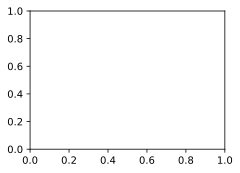

In [13]:
import math
import d2l_torch as d2l
from torch import nn
import torch


num_hiddens, num_layers, dropout, batch_size, num_steps = 512, 6, 0.1, 256, 10
lr, num_epochs, device = 0.005, 2, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8
key_size, query_size, value_size = 512,512,512
norm_shape = [512]

class MultiHeadAttention(nn.Module):
    def __init__(self,qurey_size,key_size,value_size,num_hiddens,num_heads,dropout,use_bias=False) -> None:
        super(MultiHeadAttention,self).__init__()
        self.num_heads=num_heads
        self.attention=d2l.DotProductAttention(dropout)
        self.Wq=nn.Linear(qurey_size,num_hiddens,bias=use_bias)
        self.Wk=nn.Linear(key_size,num_hiddens,bias=use_bias)
        self.Wv=nn.Linear(value_size,num_hiddens,bias=use_bias)
        self.Wo=nn.Linear(num_hiddens,num_hiddens,bias=use_bias)

    def forward(self,query,key,value,valid_len):
        query=d2l.transpose_qkv(self.Wq(query),self.num_heads)
        key=d2l.transpose_qkv(self.Wk(key),self.num_heads)
        value=d2l.transpose_qkv(self.Wo(value),self.num_heads)

        if valid_len is not None:
            valid_lens = torch.repeat_interleave(
                valid_len, repeats=self.num_heads, dim=0)

        output=self.attention(query,key,value,valid_lens)
        output_cat=d2l.transpose_output(output,self.num_heads)
        return self.Wo(output_cat)

class PositionWiseFFN(nn.Module):
    def __init__(self, num_input, num_hiddens, num_output) -> None:
        super(PositionWiseFFN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_input, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_output)
        )

    def forward(self, X):
        return self.mlp(X)
# 每个Encoder块由两个子层组成，第一层是多头注意力，第二层是全连接。
# 每个子层都使用残差连接，然后再进行层归一化
class EncoderBlock(nn.Module):
    def __init__(self, query_size, key_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False) -> None:
        super().__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                                num_hiddens, num_heads, dropout,use_bias)
        self.positon = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
    	# X，多头注意力的输出，以及每个子层的输出形状都为(批处理数，序列长度，特征数512)
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.positon(Y))

# TransformerEncoder由6个EncoderBlock组成
# query=key=value=输入
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs) -> None:
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block' + str(i),
                                 EncoderBlock(query_size, key_size, value_size, num_hiddens, norm_shape,
                                              ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
        return X



# 每个Decoder块由三个子层组成，第一层是带掩码多头注意力，第二层是多头注意力，第三层是全连接。
# 每个子层都使用残差连接，然后再进行层归一化
# 第一层的掩码使得，Decoder第i位的token预测结果只依赖前i-1位的token
class DecoderBlock(nn.Module):

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, use_bias=False) -> None:
        super(DecoderBlock, self).__init__()
        self.i=i

        self.mask_attention = MultiHeadAttention(key_size, query_size,
                                                     value_size, num_hiddens, num_heads, dropout,use_bias)
        self.attention=MultiHeadAttention(key_size, query_size,
                                                     value_size, num_hiddens, num_heads, dropout,use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)
        self.addnorm3 = d2l.AddNorm(norm_shape, dropout)

    def forward(self,X,state):
        enc_outputs,enc_valid_lens=state[0],state[1]

        batch_size, num_steps, _ = X.shape
        # 可以用来实现mask，只看当前位置之前的信息
        dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)

        X=self.addnorm1(X,self.mask_attention(X,X,X,dec_valid_lens))
        X=self.addnorm2(X,self.attention(X,enc_outputs,enc_outputs,enc_valid_lens))

        return self.addnorm3(X,self.ffn(X)),state




# TransformerDecoder由6个DederBlock组成
# query来自解码器的输入，key=query=编码器的输出
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        self.seqX=None
        return [enc_outputs, enc_valid_lens]

    def forward(self, X, state):
        # 预测的时候，Decoder前一个的预测结果作为后一个的输入
        # 训练的时候，使用X本身
        if not self.training:
            self.seqX = X if self.seqX is None else torch.cat((self.seqX, X), dim=1)
            X = self.seqX
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state


train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)


def train(net, data_iter, lr, num_epochs, tgt_vocab, device):

    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
    # 全连接层参数的初始化
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)
            # 输入分别是encoder_input,decoder_input,encoder_input的有效长度
            # decoder_input的有效长度是1,2,3...
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()

            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}')

# 训练模型
train(net, train_iter, lr, num_epochs, tgt_vocab, device)

def predict(net, src_sentence, src_vocab, tgt_vocab, num_steps,
            device):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq = []

    output_seq=[]
    for _ in range(num_steps):
      Y, dec_state = net.decoder(dec_X, dec_state)

      dec_X = Y.argmax(dim=2)
      pred = dec_X.squeeze(dim=0).type(torch.int32).item()

      if pred == tgt_vocab['<eos>']:
          break
      output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))


# engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# for eng, fra in zip(engs, fras):
#     translation= d2l.predict_seq2seq(
#         net, eng, src_vocab, tgt_vocab, num_steps, device)
#     print(f'{eng} => {translation}',
#           f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

**huggingface的transfomer模型**

In [ ]:
!pip install transformers
!pip install torch
!pip install sentencepiece

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [14]:
from transformers import MarianMTModel, MarianTokenizer

# 加载预训练模型和 tokenizer
model_name = 'Helsinki-NLP/opus-mt-en-de'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# 定义翻译函数
def translate(texts):
    # 将输入文本编码为模型的输入格式
    encoded_texts = tokenizer(texts, return_tensors='pt', padding=True)
    # 使用模型进行翻译
    translated = model.generate(**encoded_texts)
    # 解码翻译结果
    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    return translated_texts

# 示例文本
texts = [
    "Hello, how are you?",
    "This is a test of the translation model.",
    "Machine translation is a fascinating field."
]

# 翻译文本
translated_texts = translate(texts)
for text, translated in zip(texts, translated_texts):
    print(f'Original: {text}')
    print(f'Translated: {translated}')
    print()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Original: Hello, how are you?
Translated: Hallo, wie geht's?

Original: This is a test of the translation model.
Translated: Dies ist ein Test des Übersetzungsmodells.

Original: Machine translation is a fascinating field.
Translated: Maschinelle Übersetzung ist ein faszinierendes Feld.

